In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import pyfiles.lib

In [2]:
num_noise = batch_size = 100
num_hidden = 256

In [3]:
# standardization code
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), ])

# MNIST dataset
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data  = torchvision.datasets.MNIST(root='data/', train=False, transform=transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

(3, 62, 242)


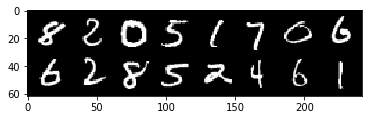

In [4]:
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
lib.imshow_grid(example_mini_batch_img[0:16,:,:])

In [5]:
class Generator(torch.nn.Module):
    """
    Generator Class for GAN
    """
    def __init__(self, input_node_size, hidden_node_size=128, output_node_size=28*28):
        super(Generator, self).__init__()
        self.num_noise = num_noise
        self.network = torch.nn.Sequential(
            
            torch.nn.Linear(input_node_size, hidden_node_size),
            torch.nn.BatchNorm1d(num_features = hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, hidden_node_size),
            torch.nn.BatchNorm1d(num_features = hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, output_node_size),
            torch.nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.network(x).view((x.shape[0], 28, 28))

In [6]:
class Discriminator(torch.nn.Module):
    """
    Discriminator Class for GAN
    """
    def __init__(self, input_node_size=28*28, hidden_node_size=128, output_node_size=1):
        super(Discriminator, self).__init__()
        
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_node_size, hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, hidden_node_size),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(hidden_node_size, output_node_size),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        return self.network(x).view(-1, 1)

Epoch 10
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


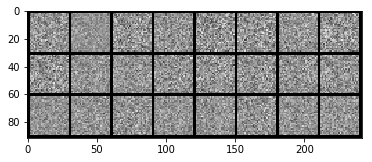

Epoch 20
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


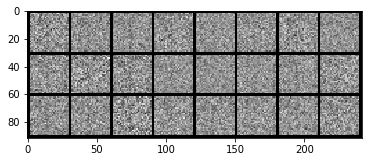

Epoch 30
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


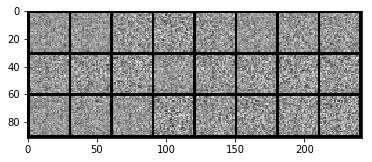

Epoch 40
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


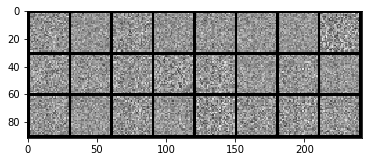

Epoch 50
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


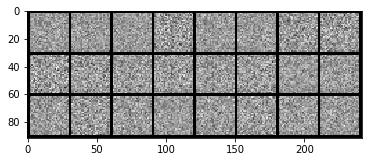

Epoch 60
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


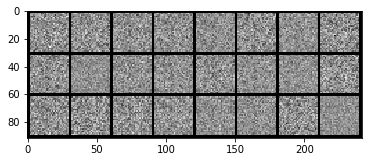

Epoch 70
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


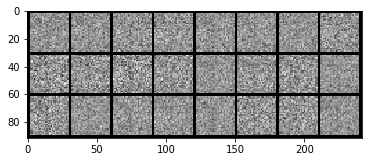

Epoch 80
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


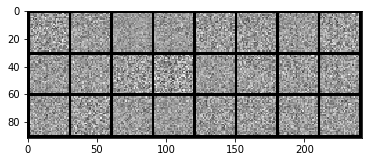

Epoch 90
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


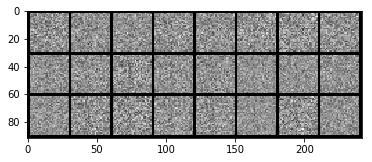

Epoch 100
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


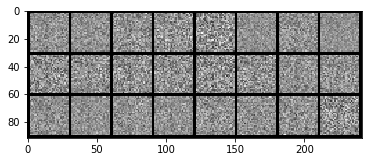

Epoch 110
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


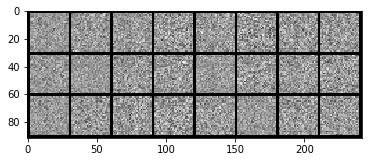

Epoch 120
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


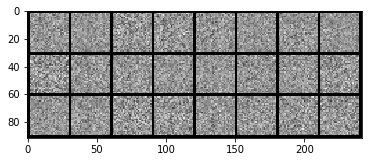

Epoch 130
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


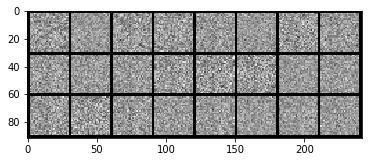

Epoch 140
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


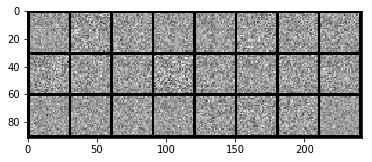

Epoch 150
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


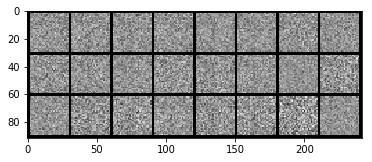

Epoch 160
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


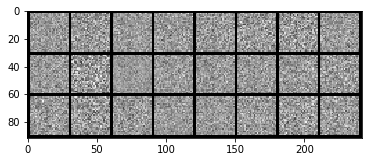

Epoch 170
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


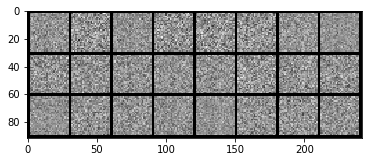

Epoch 180
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


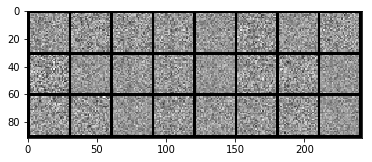

Epoch 190
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


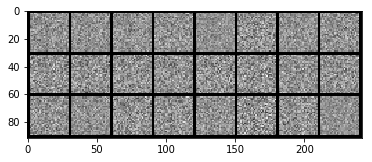

Epoch 200
Real Image Probability: 0.000, Generated Image Probability: 0.000
(3, 92, 242)


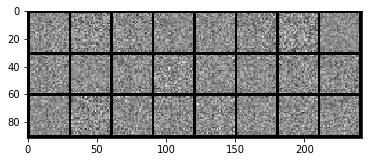

In [15]:
epochs = 200
ld = 10
gen = Generator(input_node_size=num_noise)
disc = Discriminator()
bceloss = torch.nn.BCELoss()

if torch.cuda.is_available():
    gen = gen.cuda()
    disc = disc.cuda()
    bceloss = bceloss.cuda()

#lib.init_params(gen)
#lib.init_params(disc)

'''
gen_optim = torch.optim.RMSprop(gen.parameters(), lr=0.00005)
disc_optim = torch.optim.RMSprop(disc.parameters(), lr=0.00005)
'''
gen_optim = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0, 0.9))
disc_optim = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0, 0.9))

for epoch in range(epochs):
    running_loss = 0.0
    disc.train()
    gen.train()
    
    for i, data in enumerate(train_data_loader):
        x, _ = data
        num_data = x.shape[0]
        noise = lib.sample_noise(num_data, num_noise)
        
        ones = torch.ones((num_data, 1), requires_grad=False)
        zeros = torch.zeros((num_data, 1), requires_grad=False)
        
        if torch.cuda.is_available():
            x = x.cuda()
            noise = noise.cuda()
            ones = ones.cuda()
            zeros = zeros.cuda()
        
        _x = x.view(-1, 28*28)
        gen_img = gen(noise).view(num_data, -1).detach()
                    
        ### Discriminator
        disc_optim.zero_grad()
        p_real = disc(_x)
        p_fake = disc(gen_img)
        
        # Regularization Term
        eps = torch.rand(1).item()
        x_hat = _x.detach().clone() * eps + gen_img.clone() * (1 - eps)
        x_hat.requires_grad = True
        
        '''
        _disc = type(disc)()
        _disc.load_state_dict(disc.state_dict())
        if torch.cuda.is_available():
            _disc = _disc.cuda()
        ''' 
        grad_E = disc(x_hat).sum()
        grad_E.backward()
        
        reg = ld * ((x_hat.grad ** 2).sum().sqrt() - 1) ** 2 # Regularization Term
        
        L_i = reg + p_real + p_fake
        loss_d = torch.mean(L_i)
        loss_d.backward()
        disc_optim.step()
        
        if i % 5 == 0:
            ### Generator
            gen_optim.zero_grad()
            p_fake = disc(gen(lib.sample_noise(batch_size, num_noise)).view(-1, 28*28))

            #loss_g = bceloss(p_fake, ones)
            loss_g = -torch.mean(p_fake)
            loss_g.backward()
            gen_optim.step()

    if epoch % 10 == 9:
        disc.eval()
        gen.eval()
        
        p_real = p_gen = 0.0
        noise = lib.sample_noise(24, num_noise)
        if torch.cuda.is_available():
            noise = noise.cuda()
            
        for i, data in enumerate(test_data_loader):
            x, _ = data
            #num_data = x.shape[0]
            if torch.cuda.is_available():
                x = x.cuda()
                #y = y.cuda()
                
            with torch.autograd.no_grad():
                fake_img = gen(noise).view(-1, 28*28)
                p_real += disc(x.view(-1, 28*28)).mean()
                p_gen += disc(fake_img).mean()
                
        print("Epoch %d\nReal Image Probability: %.3f, Generated Image Probability: %.3f" % (epoch+1, p_real, p_gen))
        fake_img = gen(noise).view((-1, 1, 28, 28))
        lib.imshow_grid(fake_img)
        lib.imsave(fake_img, epoch)